In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator
from qiskit import transpile

import pylatexenc

# for testing
# from random import random, randint, choice

import numpy as np
# make numpy output look better
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")

import matplotlib.pyplot as plt
# %matplotlib inline

# style
# plt.rcParams['figure.figsize'] = (10, 8)
# plt.style.use('fivethirtyeight')
plt.style.use("ggplot")

# Examples of Stabilizer Codes

## Five-Qubit Error-Correcting Code

We implement here the [Quantum Five-Qubit Error Correcting Code](https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code), which is a $[[5, 1, 3]]$ code.  We then run experiments with encoded two qubits having the probability of getting a *Pauli error* (i.e., and $X$, $Y$, or $Z$ error) in each of the encoded qubits with a given probability $p$, for a few values of $p$.  So, each error, $X$, $Y$, and $Z$, has a probability of $p$ of occurring in each encoded qubits.  (Therefore, the probability of an encoded qubit having no error is $1 - 3p$.)  We present a visualization of the results.

### Stabilizer Group

We follow Nielsen and Chuang's [Quantum Computation and Quantum Information](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview), Section 10.5.6.

The generators of the stabilizer group are:

$$
  \begin{align*}
    g_0 &= X \otimes Z \otimes Z \otimes X \otimes \mathbb{I}. \\
    g_1 &= \mathbb{I} \otimes X \otimes Z \otimes Z \otimes X ,\\
    g_2 &= X \otimes \mathbb{I} \otimes X \otimes Z \otimes Z ,\\
    g_3 &= Z \otimes X \otimes \mathbb{I} \otimes X \otimes Z, \\
  \end{align*}
$$

Let's encode this information:

In [2]:
g5_gates_str = [
    ["x", "z", "z", "x", "i"],
    ["i", "x", "z", "z", "x"],
    ["x", "i", "x", "z", "z"],
    ["z", "x", "i", "x", "z"],
]

Now we create a function to generate the circuits for each element of the group:

In [3]:
def stabilizer_gen(gates_str):
    g = []
    for gates in gates_str:
        quantum_register = QuantumRegister(size=len(gates), name="x")
        circuit = QuantumCircuit(quantum_register)
        for j, gate in enumerate(gates):
            if gate == "x":
                circuit.x(j)
            elif gate == "z":
                circuit.z(j)
        g.append(circuit)
    return g

Let's save the generators in `g5`:

In [4]:
g5 = stabilizer_gen(g5_gates_str)

Let's take a look at one of them:

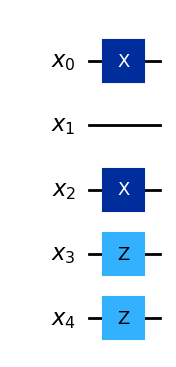

In [5]:
i = 2
g5[i].draw("mpl")

### Encoding

According to Nielsen and Chuang, the logical qubits are given by:

$$
\begin{align*}
\left| 0 \right\rangle_L 
& = \frac{1}{4} (\phantom{+} \left|00000\right\rangle -\left|11000\right\rangle + \left|10100\right\rangle -\left|01100\right\rangle \\
&\qquad +\left|10010\right\rangle + \left|01010\right\rangle -\left|00110\right\rangle -\left|11110\right\rangle \\
& \qquad -\left|10001\right\rangle + \left|01001\right\rangle + \left|00101\right\rangle-\left|11101\right\rangle ,\\ 
& \qquad-\left|00011\right\rangle -\left|11011\right\rangle-\left|10111\right\rangle -\left|01111\right\rangle) \\
\left| 1 \right\rangle_L 
&= \frac{1}{4} (-\left|10000\right\rangle -\left|01000\right\rangle -\left|00100\right\rangle -\left|11100\right\rangle \\
&\qquad -\left|00010\right\rangle +\left|11010\right\rangle +\left|10110\right\rangle -\left|01110\right\rangle \\
&\qquad  -\left|00001\right\rangle -\left|11001\right\rangle +\left|10101\right\rangle +\left|01101\right\rangle \\
&\qquad -\left|10011\right\rangle +\left|01011\right\rangle -\left|00111\right\rangle +\left|11111\right\rangle).
\end{align*}
$$

We follow a clever construction from [Stack Exchange](https://quantumcomputing.stackexchange.com/)'s thread [Nielsen&Chuang 5-qubit quantum error-correction encoding gate](https://quantumcomputing.stackexchange.com/questions/14264/nielsenchuang-5-qubit-quantum-error-correction-encoding-gate) for the encoding:

In [6]:
def five_qubit_encoder():
    quantum_register = QuantumRegister(size=5, name="x")
    encoder_circ = QuantumCircuit(quantum_register)

    encoder_circ.z(0)
    encoder_circ.h(quantum_register[1:])
    for i in range(4):
        encoder_circ.cx(4 - i, 0)
    encoder_circ.cz(0, 4)
    for i in range(1, 5, 2):
        encoder_circ.cz(i, i + 1)
    for i in range(0, 4, 2):
        encoder_circ.cz(i, i + 1)
    return encoder_circ

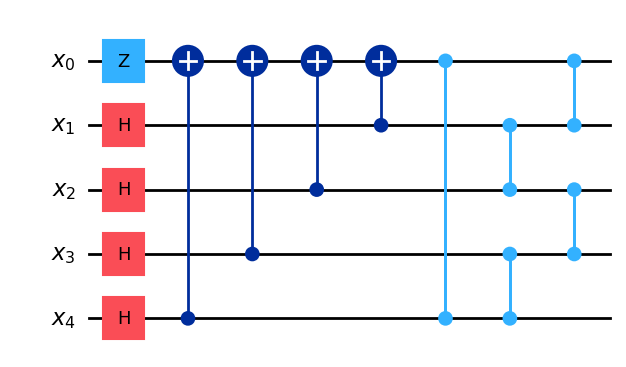

In [7]:
encoder5 = five_qubit_encoder()

encoder5.draw("mpl")

Let's check that the coefficients are indeed correct.  We start with $\left| 0 \right\rangle_L$.

In [8]:
logical5_0 = Statevector(encoder5)

Firstly, the scalars in the linear combination should all be real:

In [9]:
for x in logical5_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should also all be $0$ or $\pm 1/4$:

In [10]:
a = np.abs(4 * logical5_0.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

Let's print the result to compare to expected value of $\left| 0 \right\rangle_L$:

In [11]:
def binary_digits(a, n):
    """
    Given a and n, returns the first n digits of the binary representation of a.

    INPUTS:
    * a: A positive integer;
    * n: the number of binary digits.

    OUTPUT:
    An array of length n containing the first n binary digits of a, from letft to right.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


for i, coef in enumerate(4 * logical5_0.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

  1: [0 0 0 0 0]
 -1: [1 1 0 0 0]
  1: [1 0 1 0 0]
 -1: [0 1 1 0 0]
  1: [1 0 0 1 0]
  1: [0 1 0 1 0]
 -1: [0 0 1 1 0]
 -1: [1 1 1 1 0]
 -1: [1 0 0 0 1]
  1: [0 1 0 0 1]
  1: [0 0 1 0 1]
 -1: [1 1 1 0 1]
 -1: [0 0 0 1 1]
 -1: [1 1 0 1 1]
 -1: [1 0 1 1 1]
 -1: [0 1 1 1 1]


So, it matches!

Now, we repeat the idea for $\left| 1 \right\rangle_L$.  To encode it, we need to use $\left|10000\right\rangle$ as input:

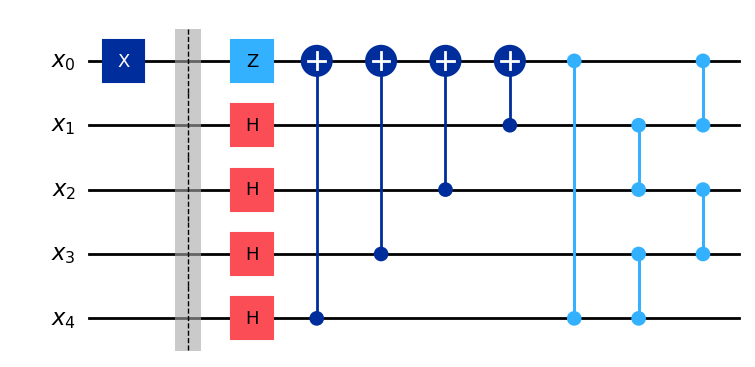

In [12]:
quantum_register = QuantumRegister(size=5, name="x")
circ = QuantumCircuit(quantum_register)

circ.x(0)
circ.barrier()
circ.compose(encoder5, inplace=True)

circ.draw("mpl")

Let's save the state:

In [13]:
logical5_1 = Statevector(circ)

Again, we check that the coefficients are all real:

In [14]:
for x in logical5_1.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


Now we check if they are all either $0$ or $\pm 1/4$:

In [15]:
a = np.abs(4 * logical5_1.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

And we print the result to compare to the expected expression for $\left| 1 \right\rangle_L$:

In [16]:
for i, coef in enumerate(4 * logical5_1.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

 -1: [1 0 0 0 0]
 -1: [0 1 0 0 0]
 -1: [0 0 1 0 0]
 -1: [1 1 1 0 0]
 -1: [0 0 0 1 0]
  1: [1 1 0 1 0]
  1: [1 0 1 1 0]
 -1: [0 1 1 1 0]
 -1: [0 0 0 0 1]
 -1: [1 1 0 0 1]
  1: [1 0 1 0 1]
  1: [0 1 1 0 1]
 -1: [1 0 0 1 1]
  1: [0 1 0 1 1]
 -1: [0 0 1 1 1]
  1: [1 1 1 1 1]


Again, it matches!

Finally, let's check that $\left| 0 \right\rangle_L$ and $\left| 1 \right\rangle_L$ are indeed $+1$-eigenvalues of the stabilizer group generators, i.e., the $g_i$'s.  

Let's write a function that can check it more generally.

In [17]:
def test_logical_qubit(qubit, encoder, stabilizer_group):
    n_qubits = encoder.num_qubits
    quantum_register = QuantumRegister(size=n_qubits, name="x")
    circ = QuantumCircuit(quantum_register)

    if qubit == 1:
        circ.x(0)

    circ.compose(encoder, inplace=True)

    logical = Statevector(circ)
    for i, gi in enumerate(stabilizer_group):
        output = Statevector(circ.compose(gi))
        if not np.array_equal(output.data, logical.data):
            return False

    return True

We can now check:

In [18]:
test_logical_qubit(0, encoder5, g5) and test_logical_qubit(1, encoder5, g5)

True

### Error Correction

We now introduce the error correction.  We follow [Bernard Zygelman](https://www.physics.unlv.edu/~bernard/)'s [Five and Seven Qubit Codes](https://www.physics.unlv.edu/~bernard/MATH_book/Chap9/Notebook9_3.pdf).

The idea is that if we have a single qubit operator $M$ with eigenvalues $\pm 1$, then we can determine if an eigenvector $\left| \psi \right\rangle$ has eigenvalue $1$ or $-1$ via:

<img src="M-meas.png" alt="Single Qubit Eigenvalue Flip Circuit" width="500"/>

If the measurement yields $0$, then $\left| \psi \right\rangle$ has eigenvalue $+1$, and if it yields $1$, then it has eigenvalue $-1$:

$$
\begin{align*}
\left| \psi \right\rangle \left| 0 \right\rangle
&\mapsto \frac{1}{\sqrt{2}} \left(\left| \psi \right\rangle \left| 0 \right\rangle +  \left| \psi \right\rangle \left| 1 \right\rangle \right) \\
&\mapsto \frac{1}{\sqrt{2}} \left(\left| \psi \right\rangle \left| 0 \right\rangle  \pm  \left| \psi \right\rangle \left| 1 \right\rangle \right) \\
&= \left| \psi \right\rangle \otimes \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle \pm \left| 1 \right\rangle \right) \\
&= \left| \psi \right\rangle \left| (1 - (\pm 1)) /2 \right\rangle.
\end{align*}
$$

We can apply this to $M=X$ and $M=Z$ to detect errors.  Suppose that $g_i$ has a tensor factor of $X$ in the $j$-th qubit. Then, we have that $X_j g_i = g_i X_j$, and if $\left| \psi \right\rangle$ is a $+1$-eigenstate of $g_i$, then
$$
g_i \left(X_j \left| \psi \right\rangle \right) = X_j \left(g_i \left| \psi \right\rangle \right) = X_j \left| \psi \right\rangle,
$$
i.e., $X_j \left| \psi \right\rangle$ is also a $+1$-eigenstate, and our circuit above yields a measurement of $0$.


On the other hand, since $XZ=-ZX$ and $XY = -YX$, we have that $U_j g_i = -g_i U_j$ for $U$ either $Z$ or $Y$, and then
$$
g_i \left(U_j \left| \psi \right\rangle \right) = -U_j \left(g_i \left| \psi \right\rangle \right) = -U_j \left| \psi \right\rangle,
$$
i.e., $U_j \left| \psi \right\rangle$ is now a $-1$-eigenstate, and our circuit above yields a measurement of $1$.

Similarly, if we have instead a tensor factor of $Z$ in the $j$-th qubit, we obtain a measurement of $0$ if we have an $Z$ error in the $j$-th qubit and $1$ if we have either a $Z$ or $Y$ error.

Here is the implementation:

In [19]:
def stabilizer_error_correction_circ(encoder, gates_str, barrier=False):
    register_size = len(gates_str[0])
    checks_size = len(gates_str)

    quantum_register = QuantumRegister(size=register_size, name="x")
    checks_register = AncillaRegister(size=checks_size, name="c")

    code_circ = QuantumCircuit(quantum_register, checks_register)

    if barrier:
        code_circ.barrier()

    # error detection
    code_circ.h(checks_register)
    if barrier:
        code_circ.barrier()

    for i, gates in enumerate(gates_str):
        for j, gate in enumerate(gates):
            if gate == "x":
                code_circ.cx(checks_register[i], quantum_register[j])
            elif gate == "z":
                code_circ.cz(checks_register[i], quantum_register[j])
        if barrier:
            code_circ.barrier()

    code_circ.h(checks_register)
    if barrier:
        code_circ.barrier()

    # add syndromes
    syndromes = ClassicalRegister(size=checks_size, name="s")
    code_circ.add_register(syndromes)
    code_circ.measure(checks_register, syndromes)

    return code_circ

Let's view the circuit:

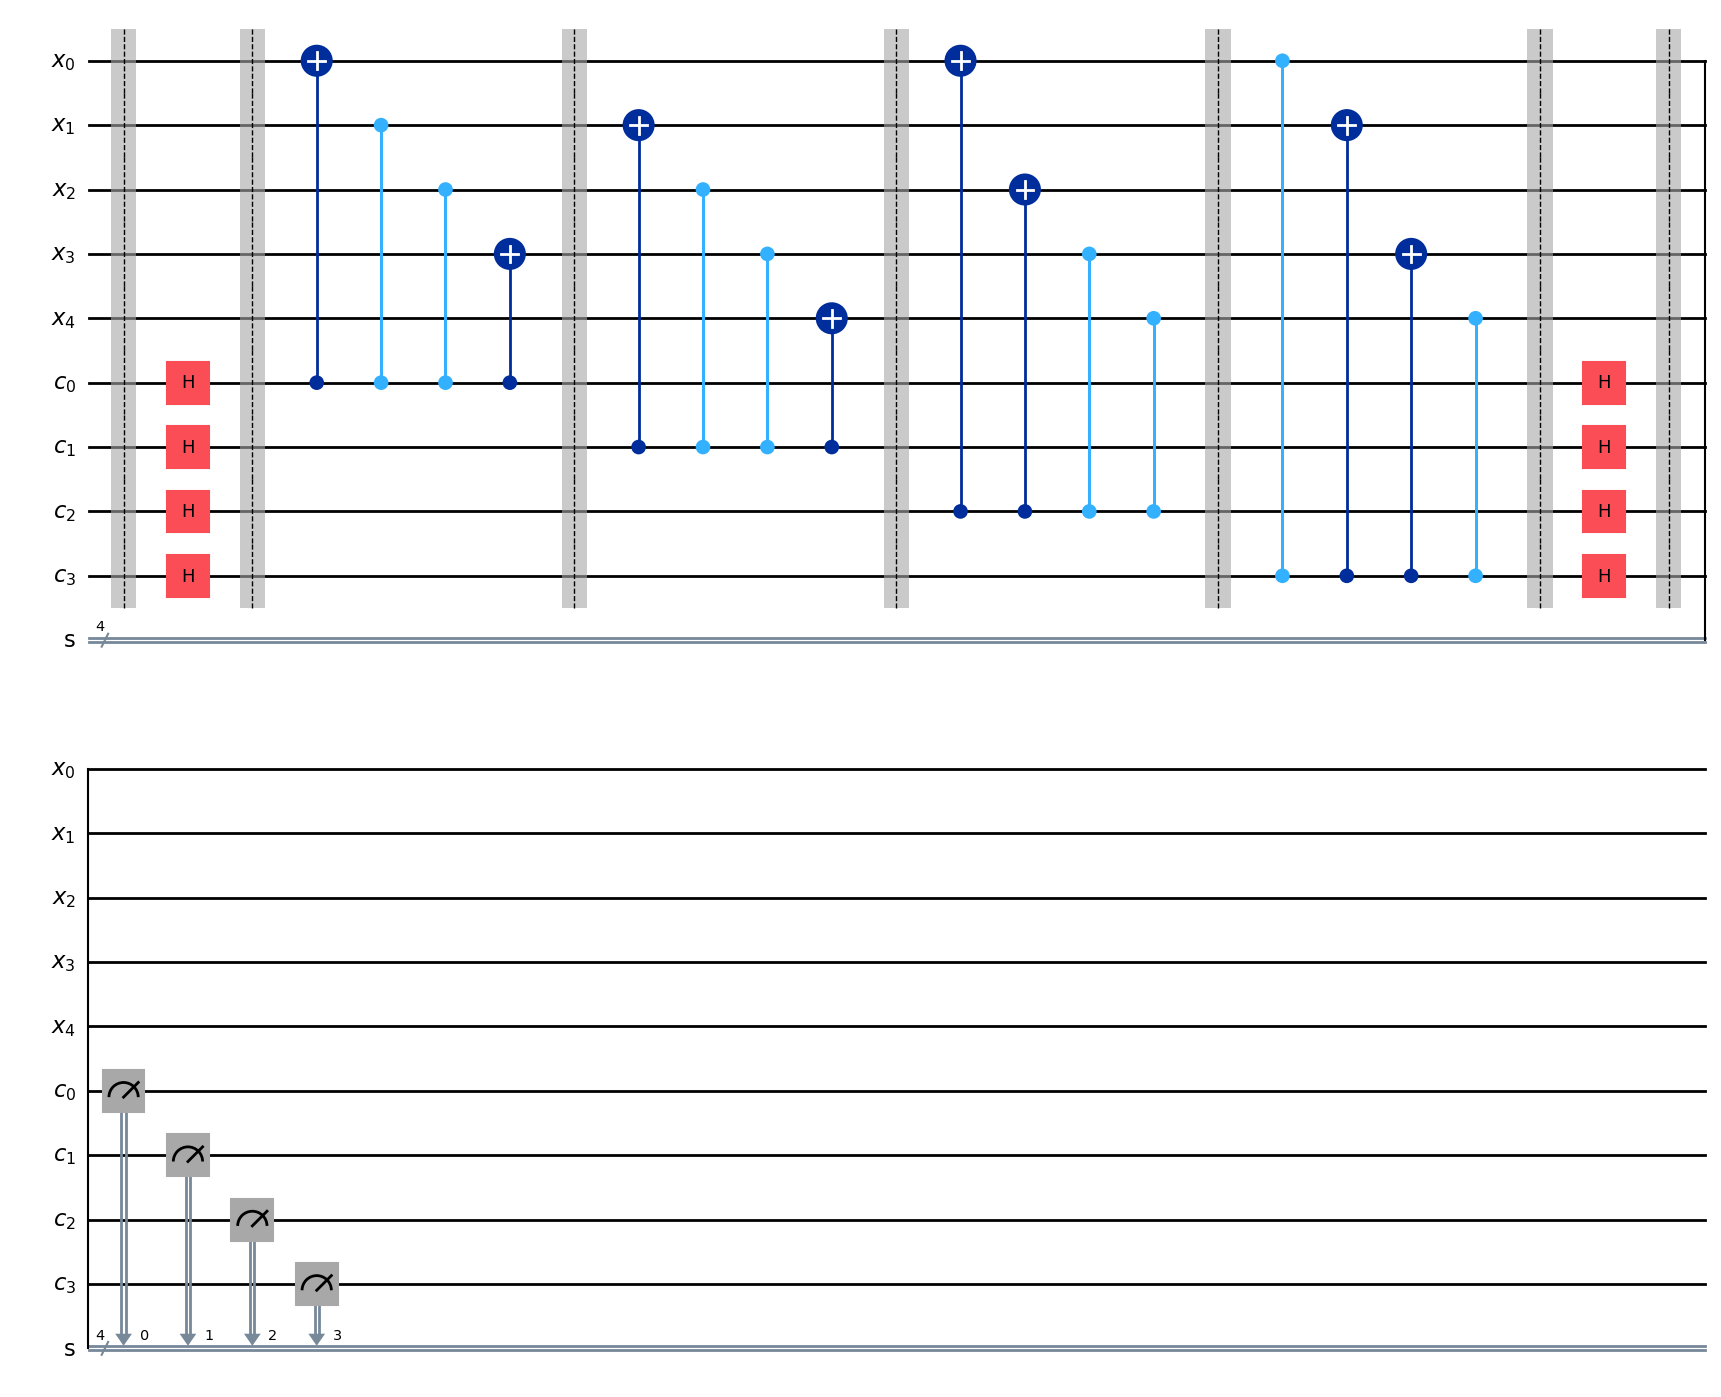

In [20]:
code5_circuit = stabilizer_error_correction_circ(encoder5, g5_gates_str, barrier=True)
code5_circuit.draw("mpl")

We can also produce a table that can gives the measurements for each Pauli error:

In [21]:
def error_table(gates_str):
    n_qubits = len(gates_str[0])
    n_syndromes = len(gates_str)

    # save table in dictionary:
    decode_dict = {}

    for qubit_error in ["x", "z", "y"]:  # possible errors
        for i in range(n_qubits):  # qubit for the error
            syndrome = [0] * n_syndromes
            for j, gi in enumerate(gates_str):  # gates
                if gi[i] not in [qubit_error, "i"]:
                    syndrome[j] = 1
            decode_dict[(qubit_error, i)] = syndrome

    return decode_dict

In [22]:
decode5_dict = error_table(g5_gates_str)

for error, syndrome in decode5_dict.items():
    print(f"{error[0]}_{error[1]}: {syndrome}")

x_0: [0, 0, 0, 1]
x_1: [1, 0, 0, 0]
x_2: [1, 1, 0, 0]
x_3: [0, 1, 1, 0]
x_4: [0, 0, 1, 1]
z_0: [1, 0, 1, 0]
z_1: [0, 1, 0, 1]
z_2: [0, 0, 1, 0]
z_3: [1, 0, 0, 1]
z_4: [0, 1, 0, 0]
y_0: [1, 0, 1, 1]
y_1: [1, 1, 0, 1]
y_2: [1, 1, 1, 0]
y_3: [1, 1, 1, 1]
y_4: [0, 1, 1, 1]


So, we have:

| Error |   Measurement  | | Error |   Measurement  | | Error |   Measurement  |
|-------|----------------|-|-------|----------------|-|-------|----------------|
| $X_0$ | $(0, 0, 0, 1)$ | | $Z_0$ | $(1, 0, 1, 0)$ | | $Y_0$ | $(1, 0, 1, 1)$ |
| $X_1$ | $(1, 0, 0, 0)$ | | $Z_1$ | $(0, 1, 0, 1)$ | | $Y_1$ | $(1, 1, 0, 1)$ |
| $X_2$ | $(1, 1, 0, 0)$ | | $Z_2$ | $(0, 0, 1, 0)$ | | $Y_2$ | $(1, 1, 1, 0)$ |
| $X_3$ | $(0, 1, 1, 0)$ | | $Z_3$ | $(1, 0, 0, 1)$ | | $Y_3$ | $(1, 1, 1, 1)$ |
| $X_4$ | $(0, 0, 1, 1)$ | | $Z_4$ | $(0, 1, 0, 0)$ | | $Y_4$ | $(0, 1, 1, 1)$ |


So, the measurements tell us which error occurred, and we can fix it by applying the same operator.  For instance, if we measure $(0,0,1,0)$ we apply $Z_2$ to the circuit.

Let's create a function that apply tests the measurements and applies the corrections based on the error table.  **Note that this function modifies the given circuit, and does not output a new one.**  

(Unfortunately, although the process is algorithmic, I was not able to find a way to implement it more generally, since we cannot add "if tests" in a loop.)

In [23]:
def add_5_qubit_correction(circuit, qubits, syndromes, decode_dict):
    """
    Adds correction for five-qubit code circuit (in-place) using a decoding table.

    INPUT:
    * circuit: the circuit containing the five-qubit code;
    * qubtis: register for the qubits and checks;
    * syndromes: syndromes containing the measurements;
    * decode_dict: dictionary containing the decoding table.
    """
    for error, values in decode_dict.items():
        with circuit.if_test((syndromes[0], values[0])):
            with circuit.if_test((syndromes[1], values[1])):
                with circuit.if_test((syndromes[2], values[2])):
                    with circuit.if_test((syndromes[3], values[3])):
                        if error[0] == "x":
                            circuit.x(qubits[error[1]])
                        elif error[0] == "z":
                            circuit.z(qubits[error[1]])
                        elif error[0] == "y":
                            circuit.y(qubits[error[1]])

Let's then add corrections our circuit:

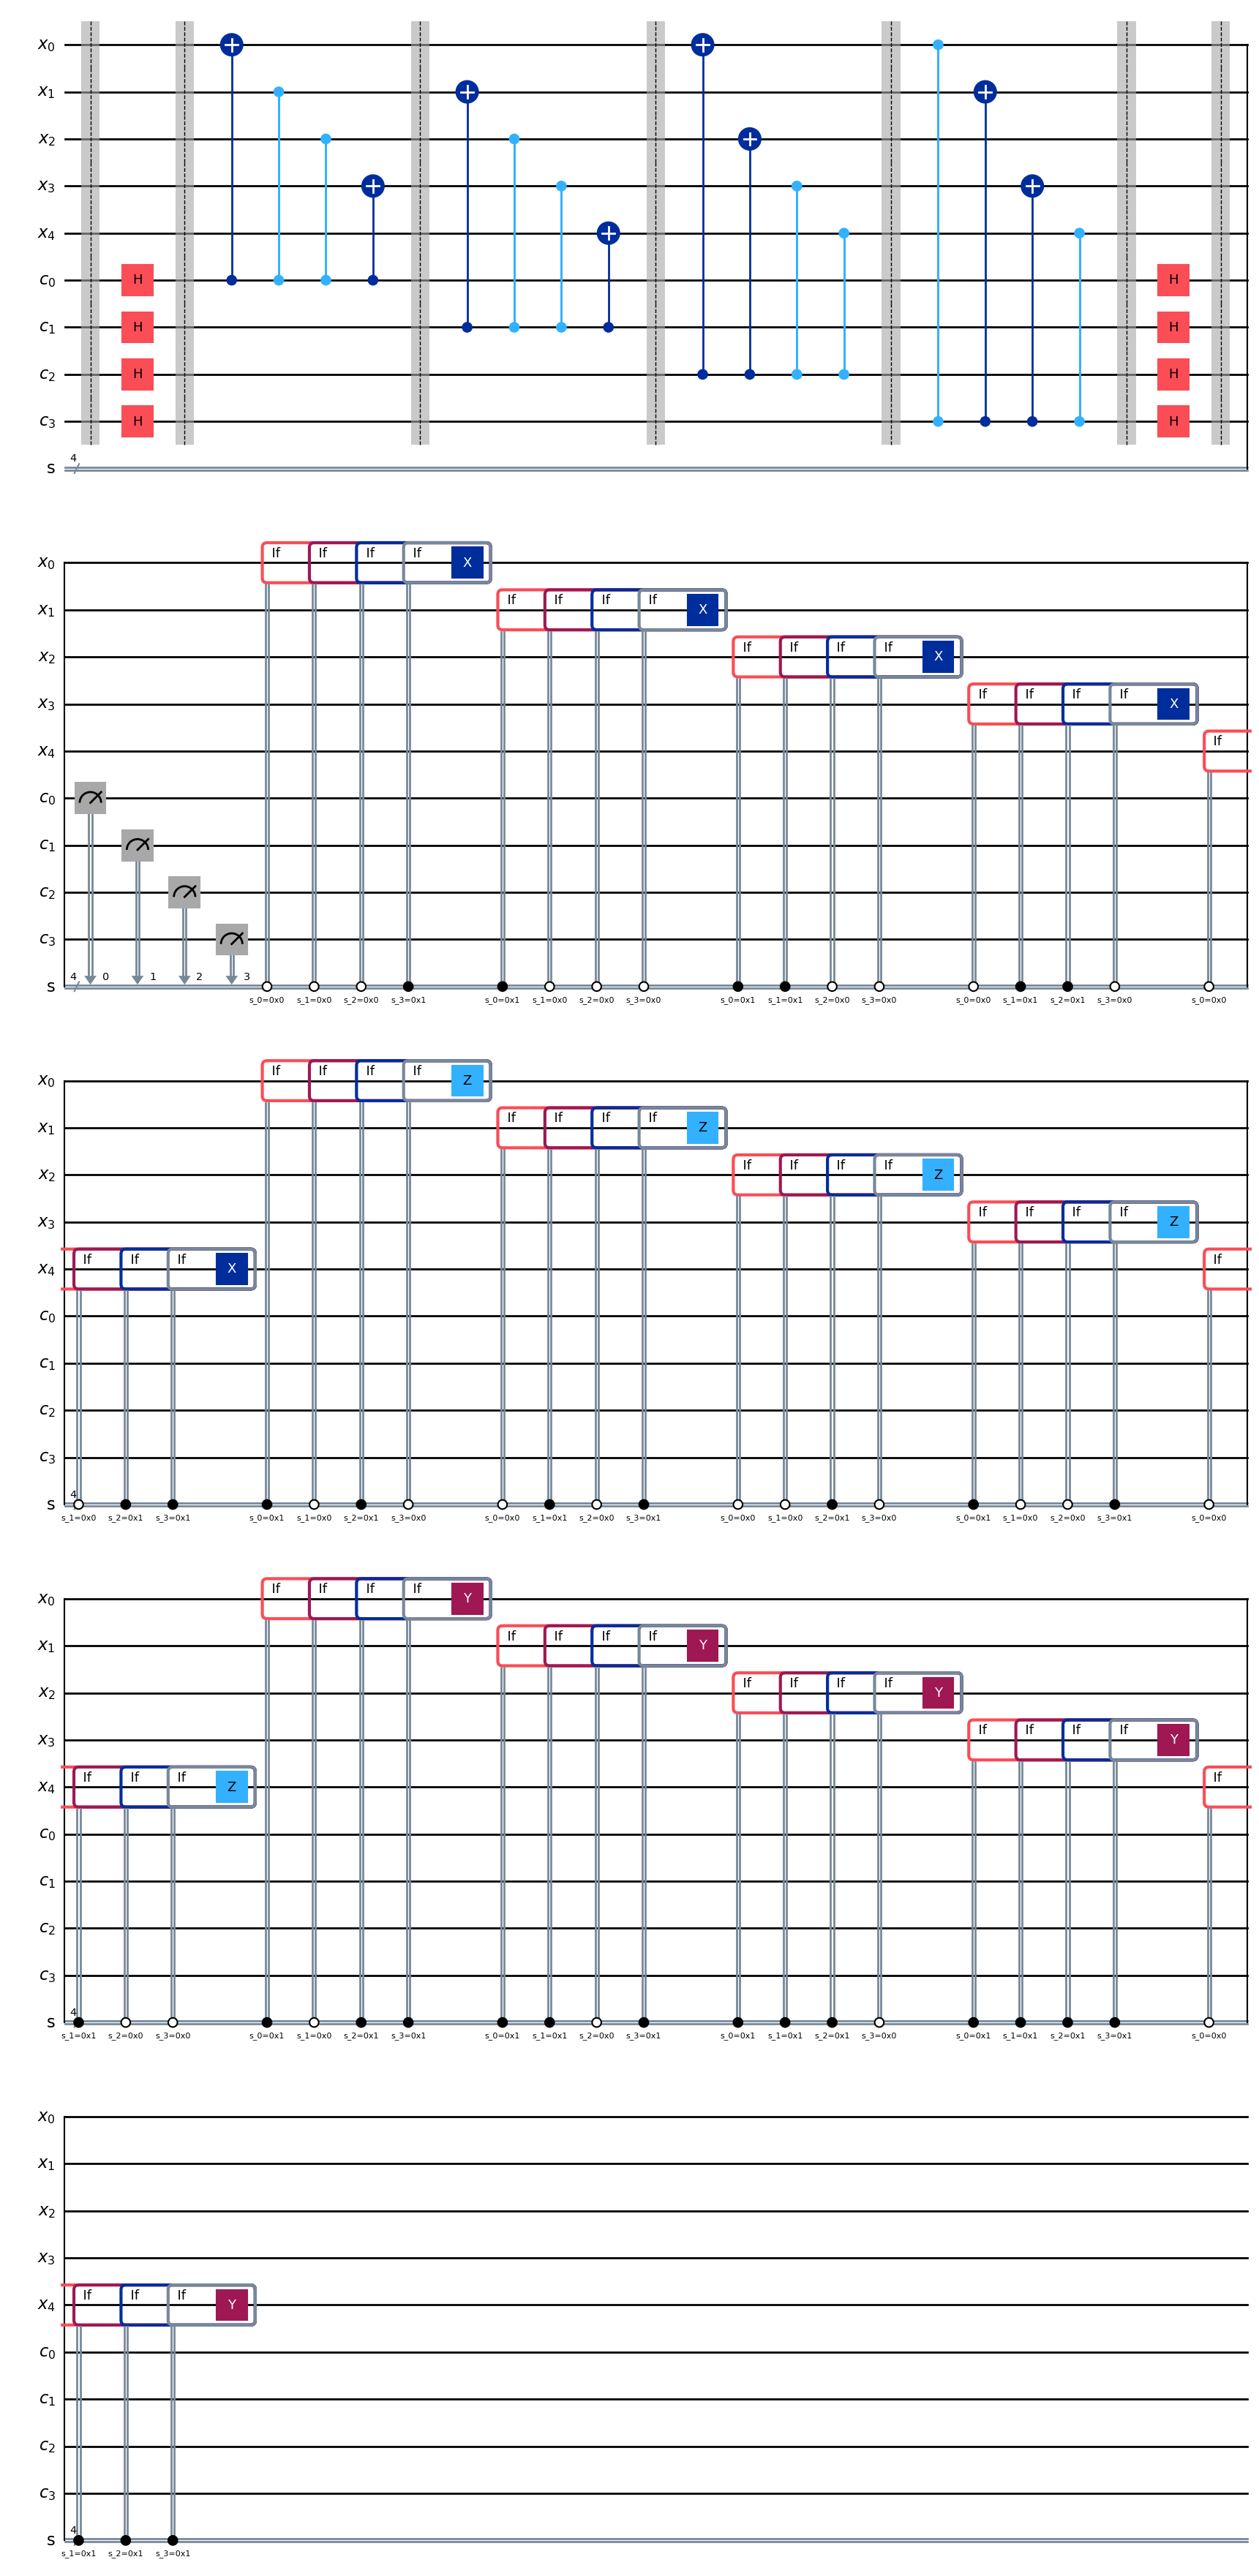

In [24]:
add_5_qubit_correction(code5_circuit, code5_circuit.qubits[0:5], code5_circuit.clbits, decode5_dict)

code5_circuit.draw("mpl")

Let's now test the correction of a single Pauli error.  The following function creates a code circuit, adds a specific error to a specific qubit after the encoding.

In [25]:
def test_error_circuit(
    encoder,
    gates_str,
    add_corrections,
    qubit,
    error_gate,
    error_position,
    barrier=False,
):
    n_qubits = len(gates_str[0])
    n_checks = len(gates_str)

    decode_dict = error_table(gates_str)

    code_circuit = stabilizer_error_correction_circ(encoder, gates_str, barrier=barrier)
    add_corrections(
        code_circuit, code_circuit.qubits[:n_qubits], code_circuit.clbits, decode_dict
    )

    quantum_register = QuantumRegister(size=n_qubits, name="x")
    checks_register = QuantumRegister(size=n_checks, name="c")
    syndromes = ClassicalRegister(size=n_checks, name="s")

    qubit_measurements = ClassicalRegister(size=n_qubits, name="meas")

    test_circuit = QuantumCircuit(quantum_register, checks_register, syndromes)

    # encode correct value
    if qubit == 1:
        test_circuit.x(quantum_register[0])
        if barrier:
            test_circuit.barrier()

    # encode
    test_circuit.compose(encoder, inplace=True)
    if barrier:
        test_circuit.barrier()

    # add error
    if error_gate == "x":
        test_circuit.x(quantum_register[error_position])
    elif error_gate == "y":
        test_circuit.y(quantum_register[error_position])
    elif error_gate == "z":
        test_circuit.z(quantum_register[error_position])
    if barrier:
        test_circuit.barrier()

    # add code
    test_circuit.compose(code_circuit, inplace=True)
    if barrier:
        test_circuit.barrier()

    # decode
    test_circuit.compose(encoder.inverse(), inplace=True)
    if barrier:
        test_circuit.barrier()

    # measure
    test_circuit.add_register(qubit_measurements)
    test_circuit.measure(quantum_register, qubit_measurements)

    return test_circuit

So, let's create the circuit to test the error-correcting:

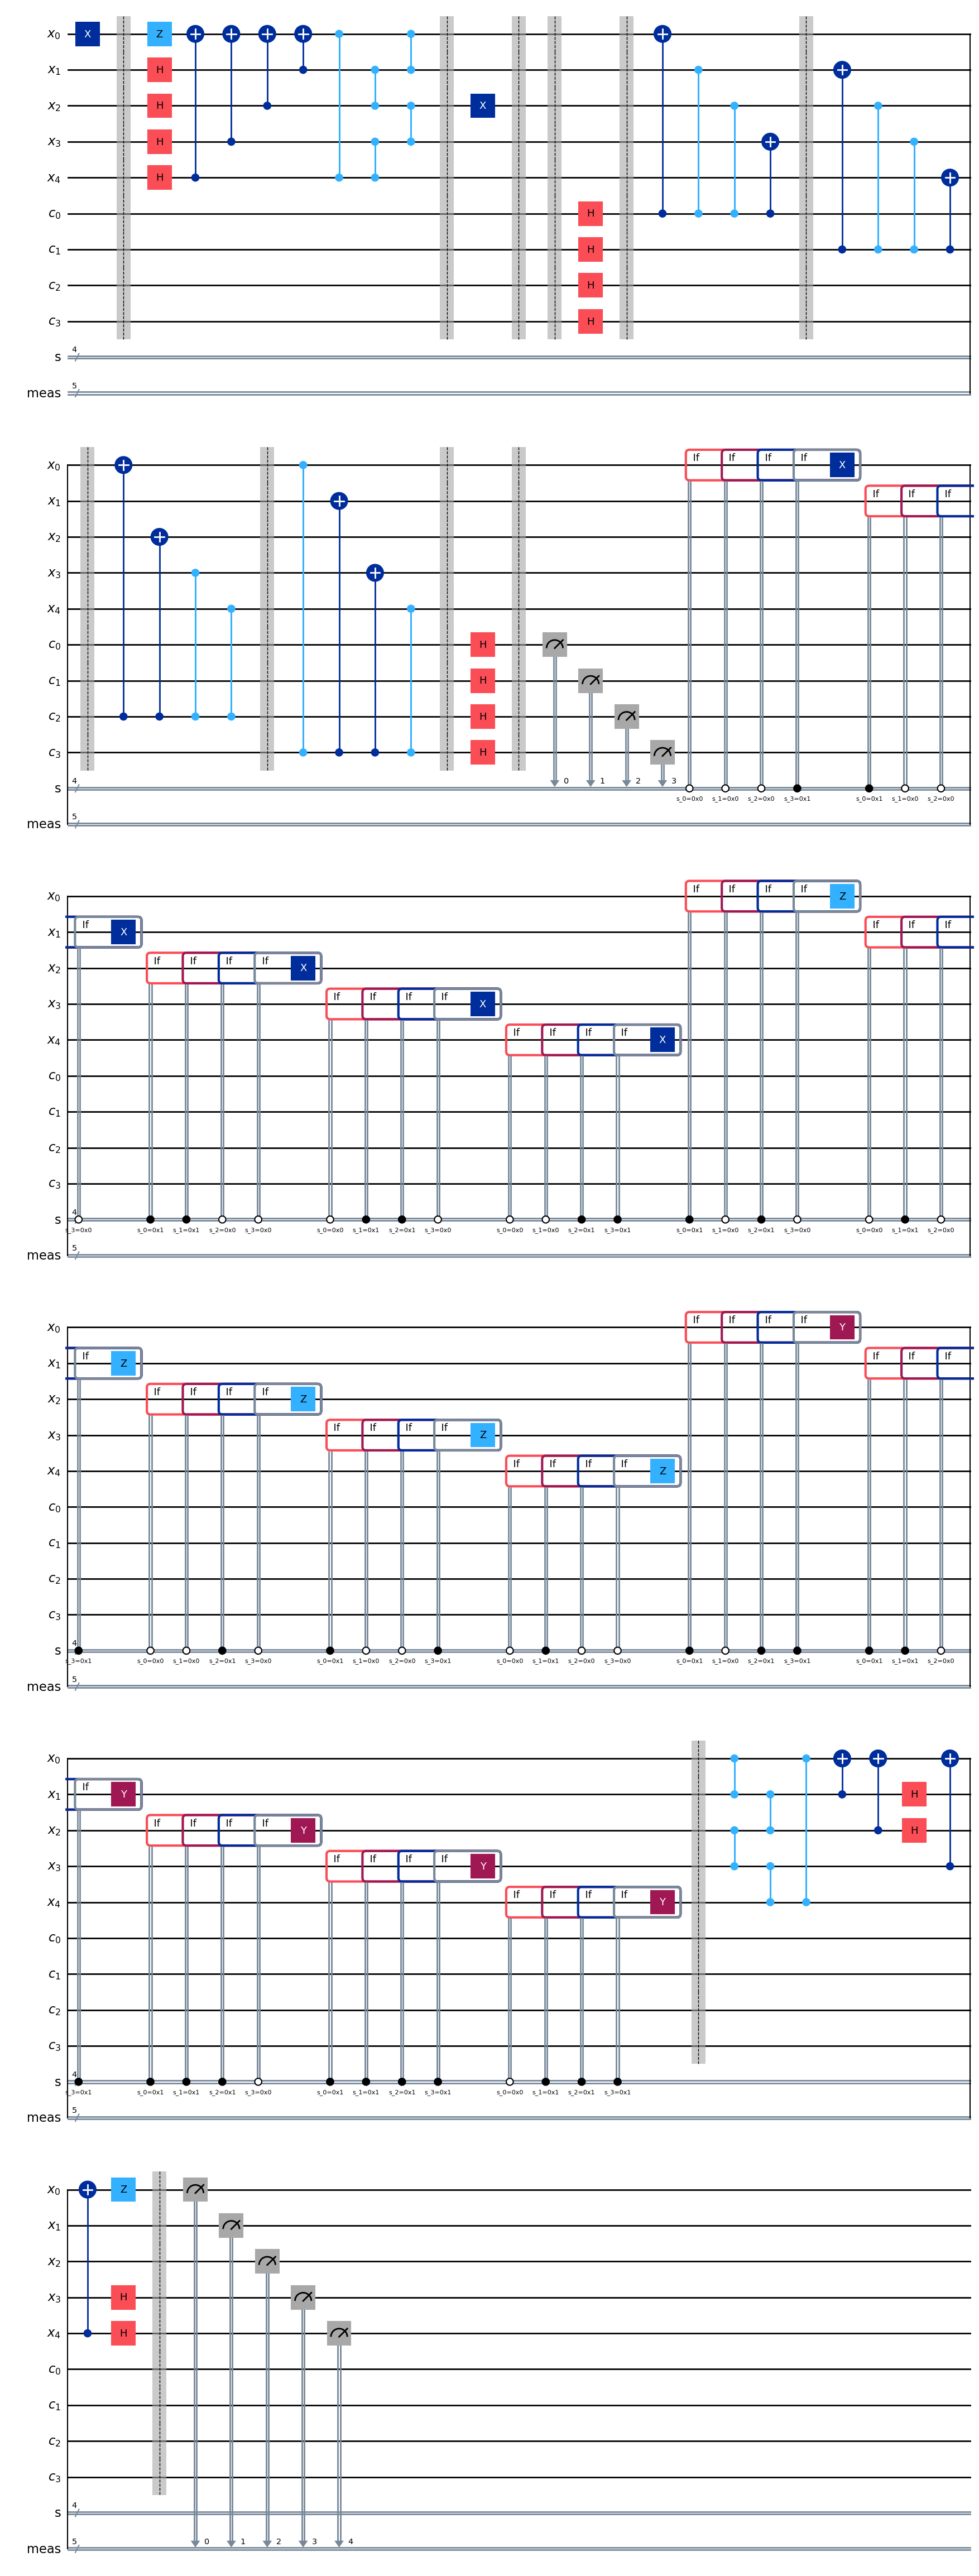

In [26]:
# change these to test:
encoded_qubit = 1
error_gate = "x"
error_position = 2

test_error_circuit(
    encoder5, g5_gates_str, add_5_qubit_correction, encoded_qubit, error_gate, error_position, barrier=True
).draw("mpl")

In [28]:
# change these to test:
encoded_qubit = 1
error_gate = "x"
error_position = 2

test5_circ = test_error_circuit(
    encoder5, g5_gates_str, add_5_qubit_correction, encoded_qubit, error_gate, error_position, barrier=True
)

Now, a function for individual tests:

In [61]:
def test_error_one_sim(
    encoder, gates_str, add_correction, qubit, error_gate, error_position
):
    n_qubits = len(gates_str[0])
    
    circ = test_error_circuit(
        encoder, gates_str, add_correction, qubit, error_gate, error_position, barrier=False
    )

    simulator = AerSimulator()

    # Transpile the circuit for the backend
    compiled_circuit = transpile(circ, simulator)
    
    # Run the circuit -- shot probably could be 1...
    job = simulator.run(compiled_circuit, shots=10)
    
    # Get the measurement counts
    counts = job.result().get_counts()

    return list(counts.keys())[0].split()[0][::-1] == str(qubit) + (n_qubits - 1) * "0"

One test:

In [30]:
# change these to test:
encoded_qubit = 1
error_gate = "x"
error_position = 2

test_error_one_sim(
    encoder5,
    g5_gates_str,
    add_5_qubit_correction,
    encoded_qubit,
    error_gate,
    error_position,
)

True

We can now do a full test for all possible one qubit errors:

In [62]:
def test_error_full(encoder, gates_str, add_correction):
    n_qubits = len(gates_str[0])

    for qubit in [0, 1]:
        for error_gate in ["x", "y", "z"]:
            for error_position in range(n_qubits):
                if not test_error_one_sim(
                    encoder,
                    gates_str,
                    add_correction,
                    qubit,
                    error_gate,
                    error_position,
                ):
                    print(f"Failed for {qubit = }, {error_gate = }, {error_position = }")
                    return False

    return True

In [32]:
test_error_full(encoder5, g5_gates_str, add_5_qubit_correction)

True

So, indeed the code can fully correct a single Pauli error in any encoded qubit.

### Two Qubit Encoding/Decoding and Test

We now need to produce a circuit that encodes two qubits using the five-qubit code, but introduces error according to a given probability.  But let's create a more general function, that can do it for other stabilizer codes and any number of qubits:

In [33]:
def n_qubit_plus_errors_circ(n, gates_str, encoder, add_correction, qubits, p, barrier=False):
    n_qubits = len(gates_str[0])
    n_ancillas = len(gates_str)

    code_circ = stabilizer_error_correction_circ(encoder, gates_str, barrier=barrier)
    decode_dict = error_table(gates_str)

    # registers
    quantum_register = QuantumRegister(size=n * n_qubits, name="x")
    checks_register = AncillaRegister(size=n * n_ancillas, name="c")
    syndromes = ClassicalRegister(size=n * n_ancillas, name="s")

    # circuit
    circ = QuantumCircuit(
        quantum_register,
        checks_register,
        syndromes,
    )

    # set initial state
    for i in range(n):
        if qubits[i]:
            circ.x(quantum_register[i * n_qubits])
        if barrier:
            circ.barrier()

    # encoders
    for i in range(n):
        circ.compose(
            encoder,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )
        if barrier:
            circ.barrier()

    # random errors
    error_occurred = ["i"] * (n * n_qubits)
    for i in range(n * n_qubits):
        rnd = np.random.random(3)
        # X error
        if rnd[0] < p:
            circ.x(quantum_register[i])
            error_occurred[i] = "x"
        # Y error
        if rnd[1] < p:
            circ.y(quantum_register[i])
            if error_occurred[i] == "i":
                error_occurred[i] = "y"
            else:
                error_occurred[i] += "y"
        # Z error
        if rnd[2] < p:
            circ.z(quantum_register[i])
            if error_occurred[i] == "i":
                error_occurred[i] = "z"
            else:
                error_occurred[i] += "z"
        # reverse order to see it as composition (right to left)
        error_occurred[i] = error_occurred[i][::-1]

    if barrier:
        circ.barrier()

    # encoding + correction
    for i in range(n):
        circ.compose(
            code_circ,
            qubits=list(range(i * n_qubits, (i + 1) * n_qubits))
            + list(
                range(
                    n * n_qubits + i * n_ancillas, n * n_qubits + (i + 1) * n_ancillas
                )
            ),
            clbits=syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            inplace=True,
        )
        if barrier:
            circ.barrier()

    # recovery
    for i in range(n):
        add_correction(
            circ,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            decode_dict,
        )
        if barrier:
            circ.barrier()

    # decoding
    for i in range(n):
        circ.compose(
            encoder.inverse(),
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )
        if barrier:
            circ.barrier()

    # add measurements
    qubit_measurements = ClassicalRegister(size=n * n_qubits, name="meas")
    circ.add_register(qubit_measurements)
    circ.measure(quantum_register, qubit_measurements)

    return circ, error_occurred

We can now apply it to our particular case:

In [34]:
def two_qubit_plus_errors_5_circ(qubits, p, barrier=False):

    g5_gates_str = [
        ["x", "z", "z", "x", "i"],
        ["i", "x", "z", "z", "x"],
        ["x", "i", "x", "z", "z"],
        ["z", "x", "i", "x", "z"],
    ]

    return n_qubit_plus_errors_circ(
        2,
        g5_gates_str,
        five_qubit_encoder(),
        add_5_qubit_correction,
        qubits,
        p,
        barrier=barrier,
    )

Let's test it then:

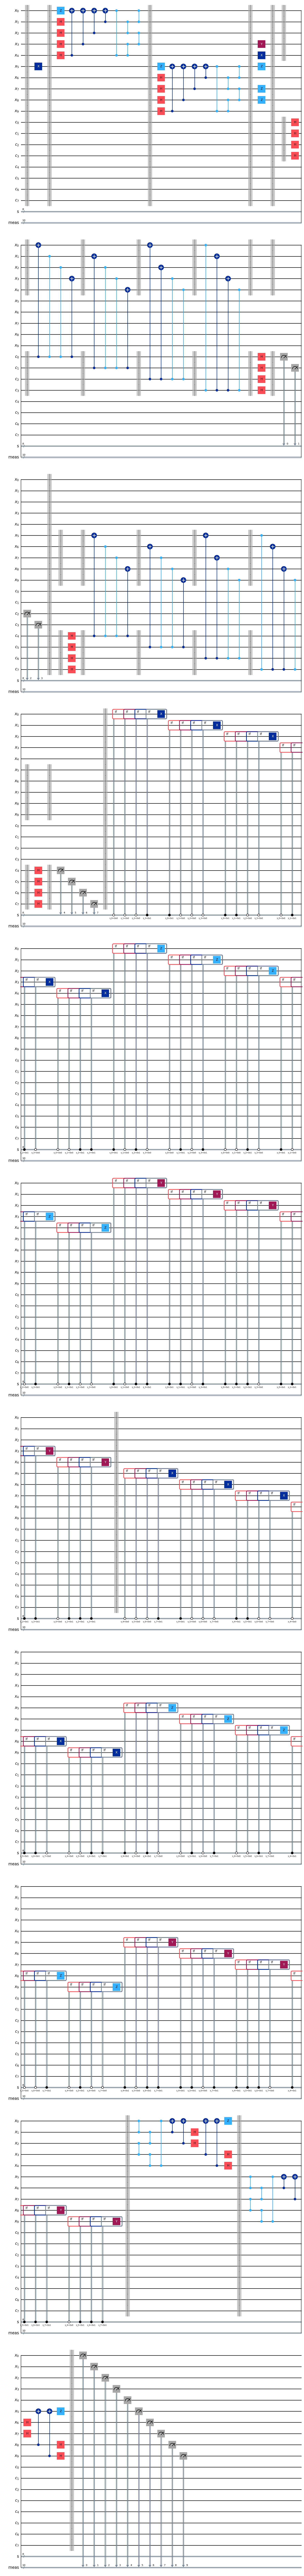

In [35]:
qubits = (0, 1)
p = 0.1

circ, error = two_qubit_plus_errors_5_circ(qubits, p, barrier=True)
circ.draw("mpl")

In [36]:
error

['i', 'i', 'i', 'y', 'x', 'z', 'i', 'z', 'z', 'i']

To perform tests and provide an empirical probability the our code we fix all errors when there is a probability of $p$ that a Pauli error occurs in each encoded qubit, we need to perform simulations.

Again, we will start with a more general function, that works for different stabilizer codes, and use $n$ encoded qubits:

In [37]:
def n_qubit_plus_errors_sim(
    n, gates_str, encoder, add_correction, qubits, p, shots=10
):

    circ, error_occurred = n_qubit_plus_errors_circ(
        n, gates_str, encoder, add_correction, qubits, p, barrier=False
    )

    n_qubits = (circ.num_qubits - circ.num_ancillas) // n

    # simulation
    simulator = AerSimulator()

    # Transpile the circuit for the backend
    compiled_circuit = transpile(circ, simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=shots)

    # Get the measurement counts
    counts = job.result().get_counts()

    # check results
    # more than one result?
    results = {qubits.split()[0] for qubits in counts}
    if len(results) > 1:
        return False, error_occurred

    # REVERSE the result!
    result = results.pop()[::-1]

    # get the logical form of each qubit
    result_split = [result[i * n_qubits: (i + 1) * n_qubits] for i in range(n)]

    # check
    for res, qubit in zip(result_split, qubits):
        if res != str(int(qubit)) + "0" * (n_qubits - 1):
            return False, error_occurred

    return True, error_occurred

And, again, we use it for our particular case:

In [38]:
def two_qubit_plus_errors_5_sim(qubits, p, shots=10):
    g5_gates_str = [
        ["x", "z", "z", "x", "i"],
        ["i", "x", "z", "z", "x"],
        ["x", "i", "x", "z", "z"],
        ["z", "x", "i", "x", "z"],
    ]

    return n_qubit_plus_errors_sim(
        2,
        g5_gates_str,
        five_qubit_encoder(),
        add_5_qubit_correction,
        qubits,
        p,
    )

So, let's try it once:

In [39]:
qubits = (1, 1)
p = 0.05

two_qubit_plus_errors_5_sim(qubits, p)

(True, ['i', 'i', 'i', 'z', 'i', 'i', 'i', 'i', 'i', 'z'])

Again, if only at most one error occurs in each of the first and last five qubits, the code should correct the error.

Let's now collect data for different values of $p$.  (**Note:** It can take a long time to run it!)

In [36]:
%%time
max_prob = 0.17
step = 0.01

xs = np.arange(0, max_prob + step, step)
ys = np.zeros_like(xs)

# number of tries for each p
number_of_tries = 100

for i, p in enumerate(xs):
    count = 0
    for _ in range(number_of_tries):
        qubits = np.random.randint(0, 2, 2)
        res, _ = two_qubit_plus_errors_5_sim(qubits, p)
        if res:
            count += 1
        ys[i] = count / number_of_tries

CPU times: user 36min, sys: 3.22 s, total: 36min 3s
Wall time: 10min 55s


Here are is the table with the percentage of correctly decoded pairs of qubits:

In [38]:
print(f"{'p':^6} | percentage")
print("------ | ---------- ")
for x, y in zip(xs, ys):
    print(f"{x:^6.2f} | {y:^10.2f}")

  p    | percentage
------ | ---------- 
 0.00  |    1.00   
 0.01  |    0.99   
 0.02  |    0.99   
 0.03  |    0.90   
 0.04  |    0.88   
 0.05  |    0.83   
 0.06  |    0.69   
 0.07  |    0.64   
 0.08  |    0.58   
 0.09  |    0.62   
 0.10  |    0.53   
 0.11  |    0.62   
 0.12  |    0.45   
 0.13  |    0.46   
 0.14  |    0.40   
 0.15  |    0.48   
 0.16  |    0.33   
 0.17  |    0.29   


Here is the corresponding plot:

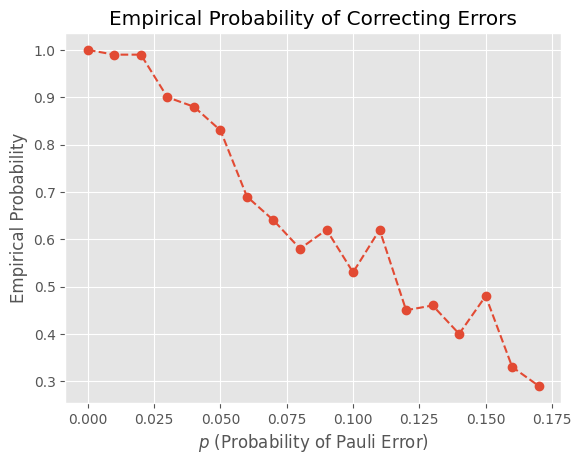

In [39]:
plt.plot(xs, ys, "--o");
plt.title("Empirical Probability of Correcting Errors")
plt.xlabel("$p$ (Probability of Pauli Error)")
plt.ylabel("Empirical Probability")

# plt.savefig("5-qb.png")

plt.show()

Below is the hard coded data from one run, with 100 examples per $p$ between $0$ and $0.17$ in steps of $0.1$:

In [43]:
xs_found_1000_5qb = np.array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17])
ys_found_1000_5qb = np.array([1.   , 0.99 , 0.948, 0.944, 0.867, 0.812, 0.754, 0.68 , 0.666,
       0.603, 0.526, 0.509, 0.489, 0.439, 0.419, 0.385, 0.38 , 0.333])

Here is the table for that run:

|   $p$   | percentage |
|---------|:----------:|
| $0.00$  |   $1.000$   |
| $0.01$  |   $0.990$   |
| $0.02$  |   $0.948$   |
| $0.03$  |   $0.944$   |
| $0.04$  |   $0.867$   |
| $0.05$  |   $0.812$   |
| $0.06$  |   $0.754$   |
| $0.07$  |   $0.680$   |
| $0.08$  |   $0.666$   |
| $0.09$  |   $0.603$   |
| $0.10$  |   $0.526$   |
| $0.11$  |   $0.509$   |
| $0.12$  |   $0.489$   |
| $0.13$  |   $0.439$   |
| $0.14$  |   $0.419$   |
| $0.15$  |   $0.385$   |
| $0.16$  |   $0.380$   |
| $0.17$  |   $0.333$   |

Here is the corresponding graph:

<img src="5-qb-1000.png" alt="Percentage Corrected for One Run"/>

## Steane's Code

We can apply similar ideas, and the functions created above, to other stabilizer codes.  Now we turn our attention to [Steane code](https://en.wikipedia.org/wiki/Steane_code), which is a $[[7,4,3]]$ code.

### Stabilizer Group

Again, we first encode the generating set for the stabilizer group:

In [40]:
g7_gates_str = [
    ["i", "i", "i", "x", "x", "x", "x"],
    ["i", "x", "x", "i", "i", "x", "x"],
    ["x", "i", "x", "i", "x", "i", "x"],
    ["i", "i", "i", "z", "z", "z", "z"],
    ["i", "z", "z", "i", "i", "z", "z"],
    ["z", "i", "z", "i", "z", "i", "z"],
]

As before, we can use the `stabilizer_gen` function to create circuits for each generator.

In [41]:
g7 = stabilizer_gen(g7_gates_str)

### Encoding

We follow [Steane's Error Correction Code](https://stem.mitre.org/quantum/error-correction-codes/steane-ecc.html).  Here is the encoder circuit given:

In [42]:
def steanes_encoder():
    quantum_register = QuantumRegister(size=7, name="x")
    encoder = QuantumCircuit(quantum_register)

    encoder.h(quantum_register[4:])
    encoder.cx(0, [1, 2])
    encoder.cx(6, [0, 1, 3])
    encoder.cx(5, [0, 2, 3])
    encoder.cx(4, [1, 2, 3])

    return encoder

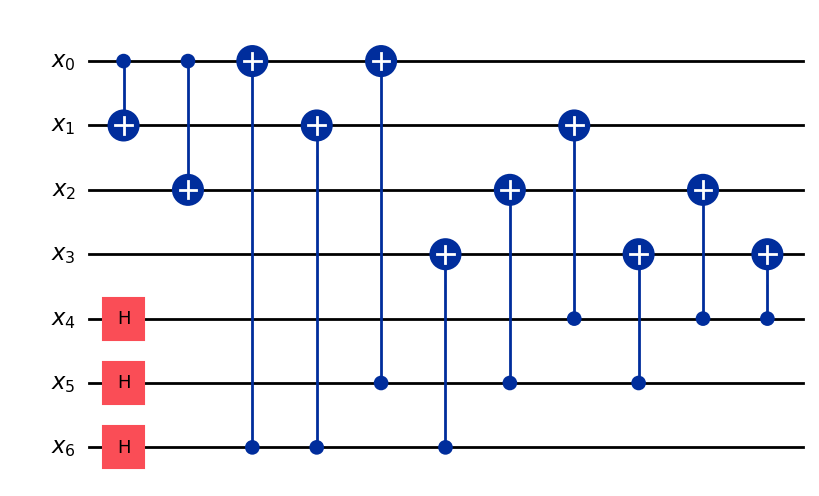

In [43]:
encoder7 = steanes_encoder()

encoder7.draw("mpl")

As seen in [EC Zoo](https://errorcorrectionzoo.org/)'s [Steane Code](https://errorcorrectionzoo.org/c/steane), the logical qubits are:
$$
\begin{align*}
\left| 0 \right\rangle_L
&= \frac{1}{\sqrt{8}} (\left|0000000\right\rangle + \left|0111100\right\rangle + \left|1011010\right\rangle + \left|1100110\right\rangle \\
&\qquad + \left|1101001\right\rangle + \left|1010101\right\rangle + \left|0110011\right\rangle + \left|0001111\right\rangle), \\
\left| 1 \right\rangle_L
&= \frac{1}{\sqrt{8}} (\left|1110000\right\rangle + \left|1001100\right\rangle + \left|0101010\right\rangle + \left|0010110\right\rangle \\
&\quad + \left|0011001\right\rangle + \left|0100101\right\rangle + \left|1000011\right\rangle + \left|1111111\right\rangle).
\end{align*}
$$

Again, let's check that the encoder works.

In [44]:
logical7_0 = Statevector(encoder7)

All scalar coefficients must be real:

In [45]:
for x in logical7_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


The also must be either $0$ or $1/\sqrt{8}$:

In [46]:
a = 8 * logical7_0.data ** 2
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

Let's check the values:

In [47]:
for i, coef in enumerate(np.sqrt(8) * logical7_0.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 7)}")

  1: [0 0 0 0 0 0 0]
  1: [0 1 1 1 1 0 0]
  1: [1 0 1 1 0 1 0]
  1: [1 1 0 0 1 1 0]
  1: [1 1 0 1 0 0 1]
  1: [1 0 1 0 1 0 1]
  1: [0 1 1 0 0 1 1]
  1: [0 0 0 1 1 1 1]


It matches $\left|0\right\rangle_L$, as expected.

Now $\left|1\right\rangle_L$:

In [48]:
quantum_register = QuantumRegister(size=7, name="x")
circ = QuantumCircuit(quantum_register)

circ.x(0)
circ.compose(encoder7, inplace=True)

logical7_1 = Statevector(circ)

Scalar coefficients must be real and either $0$ or $\frac{1}{\sqrt{8}}$:

In [49]:
for x in logical7_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


In [50]:
a = 8 * logical7_0.data ** 2
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

Here is the representation:

In [51]:
for i, coef in enumerate(np.sqrt(8) * logical7_1.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 7)}")

  1: [1 1 1 0 0 0 0]
  1: [1 0 0 1 1 0 0]
  1: [0 1 0 1 0 1 0]
  1: [0 0 1 0 1 1 0]
  1: [0 0 1 1 0 0 1]
  1: [0 1 0 0 1 0 1]
  1: [1 0 0 0 0 1 1]
  1: [1 1 1 1 1 1 1]


Again, it matches the logical qubit $\left|1\right\rangle_L$.

Finally, we can use our `test_logical_qubit` function to test them against the stabilizer group:

In [52]:
test_logical_qubit(0, encoder7, g7) and test_logical_qubit(1, encoder7, g7)

True

### Error Correction

We can use `stabilizer_error_correction_circ` to create the error-correcting circuit for Steane's code:

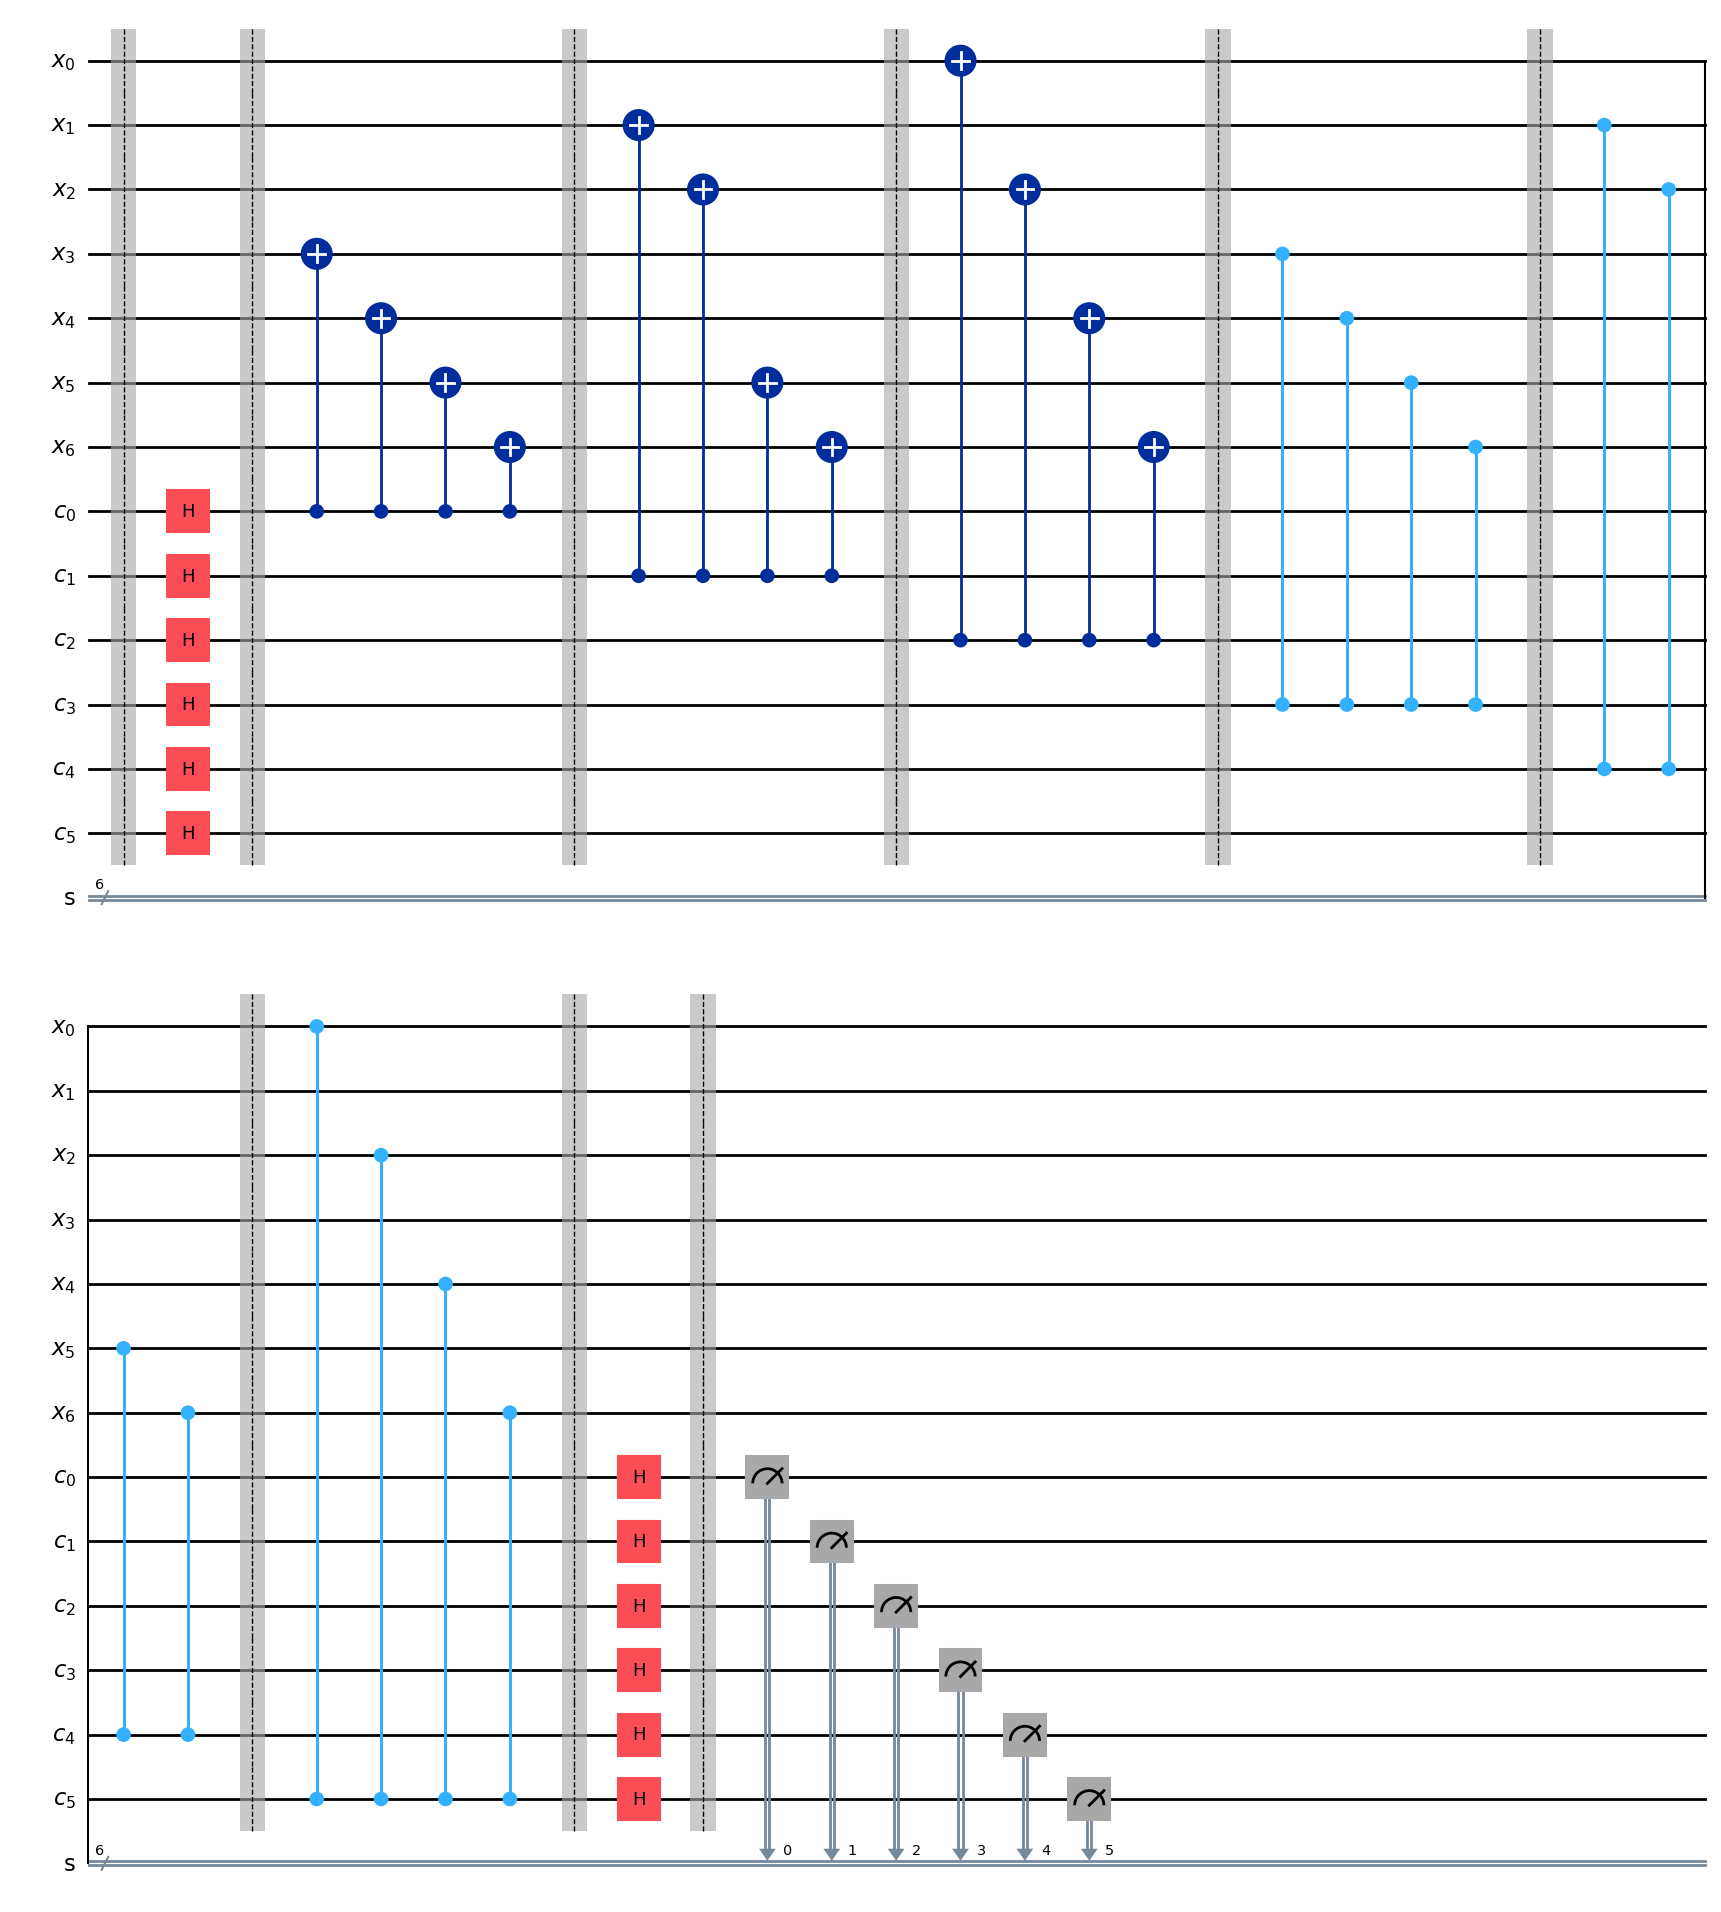

In [53]:
code7_circuit = stabilizer_error_correction_circ(encoder7, g7_gates_str, barrier=True)

code7_circuit.draw("mpl")

And `error_table` will give the error table:

In [54]:
decode7_dict = error_table(g7_gates_str)

for error, syndrome in decode7_dict.items():
    print(f"{error[0]}_{error[1]}: {syndrome}")

x_0: [0, 0, 0, 0, 0, 1]
x_1: [0, 0, 0, 0, 1, 0]
x_2: [0, 0, 0, 0, 1, 1]
x_3: [0, 0, 0, 1, 0, 0]
x_4: [0, 0, 0, 1, 0, 1]
x_5: [0, 0, 0, 1, 1, 0]
x_6: [0, 0, 0, 1, 1, 1]
z_0: [0, 0, 1, 0, 0, 0]
z_1: [0, 1, 0, 0, 0, 0]
z_2: [0, 1, 1, 0, 0, 0]
z_3: [1, 0, 0, 0, 0, 0]
z_4: [1, 0, 1, 0, 0, 0]
z_5: [1, 1, 0, 0, 0, 0]
z_6: [1, 1, 1, 0, 0, 0]
y_0: [0, 0, 1, 0, 0, 1]
y_1: [0, 1, 0, 0, 1, 0]
y_2: [0, 1, 1, 0, 1, 1]
y_3: [1, 0, 0, 1, 0, 0]
y_4: [1, 0, 1, 1, 0, 1]
y_5: [1, 1, 0, 1, 1, 0]
y_6: [1, 1, 1, 1, 1, 1]


With error table, we can manually create the function to add the error-correction part of the circuit:

In [55]:
def add_7_qubit_correction(circuit, qubits, syndromes, decode_dict):
    """
    Adds correction for Steane's code circuit (in-place) using a decoding table.

    INPUT:
    * circuit: the circuit containing the Steane's code;
    * qubtis: register for the qubits and checks;
    * syndromes: syndromes containing the measurements;
    * decode_dict: dictionary containing the decoding table.
    """
    for error, values in decode_dict.items():
        with circuit.if_test((syndromes[0], values[0])):
            with circuit.if_test((syndromes[1], values[1])):
                with circuit.if_test((syndromes[2], values[2])):
                    with circuit.if_test((syndromes[3], values[3])):
                        with circuit.if_test((syndromes[4], values[4])):
                            with circuit.if_test((syndromes[5], values[5])):
                                if error[0] == "x":
                                    circuit.x(qubits[error[1]])
                                elif error[0] == "z":
                                    circuit.z(qubits[error[1]])
                                elif error[0] == "y":
                                    circuit.y(qubits[error[1]])

Let's test it:

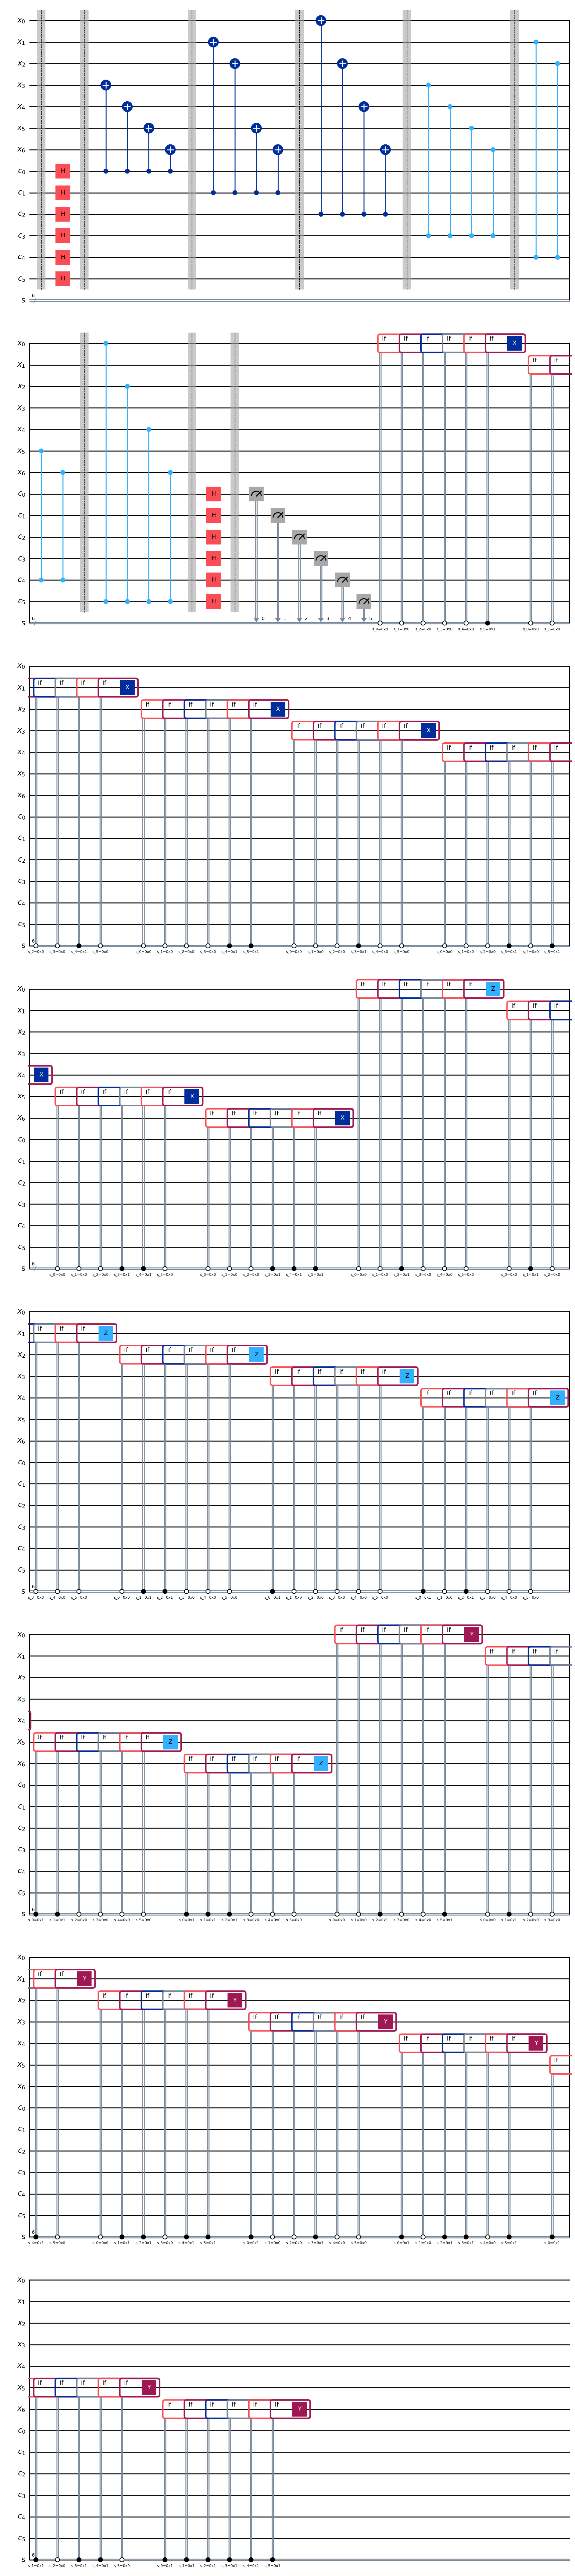

In [56]:
add_7_qubit_correction(code7_circuit, code7_circuit.qubits[0:7], code7_circuit.clbits, decode7_dict)

code7_circuit.draw("mpl")

Let's use `test_error_full` to test the error-correction:

In [63]:
test_error_full(encoder7, g7_gates_str, add_7_qubit_correction)

True

Again, it works for every Pauli error in a single qubit.

### Generating Function and Testing

We can use `n_qubit_plus_errors_circ` to generate a circuit that produces the Steane's code for one qubit, with Pauli errors appearing in each encoded qubit with probability $p$:

In [65]:
def one_qubit_plus_errors_7_circ(qubit, p, barrier=False):

    g7_gates_str = [
        ["i", "i", "i", "x", "x", "x", "x"],
        ["i", "x", "x", "i", "i", "x", "x"],
        ["x", "i", "x", "i", "x", "i", "x"],
        ["i", "i", "i", "z", "z", "z", "z"],
        ["i", "z", "z", "i", "i", "z", "z"],
        ["z", "i", "z", "i", "z", "i", "z"],
    ]

    return n_qubit_plus_errors_circ(
        1,
        g7_gates_str,
        steanes_encoder(),
        add_7_qubit_correction,
        [qubit],
        p,
        barrier=barrier,
    )

Let's test it:

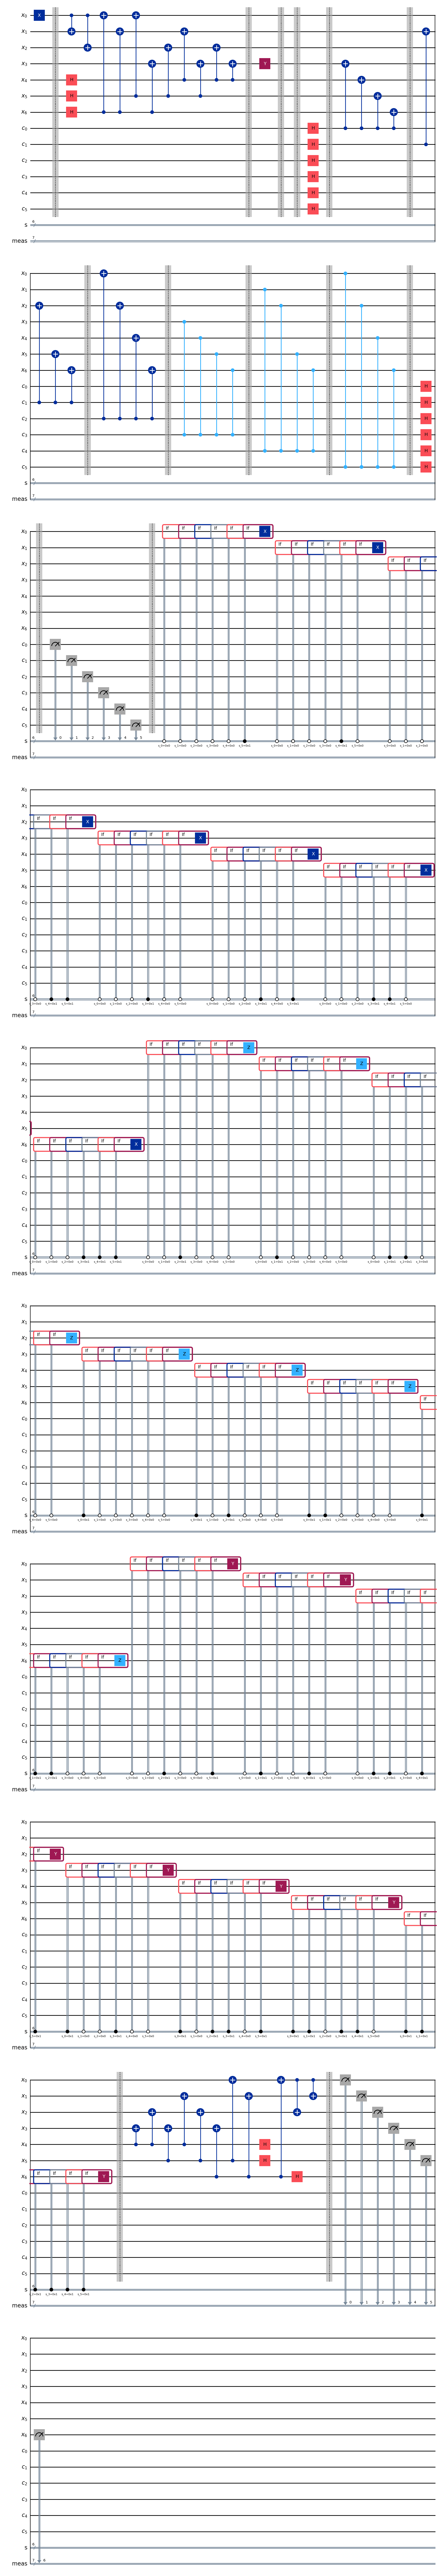

In [66]:
qubit = 1
p = 0.05

circ, error = one_qubit_plus_errors_7_circ(qubit, p, barrier=True)
circ.draw("mpl")

Let's check the error introduced:

In [67]:
error

['i', 'i', 'i', 'y', 'i', 'i', 'i']

To perform the tests, we need to introduce the simulation.  We use `n_qubit_plus_errors_sim` as before:

In [68]:
def one_qubit_plus_errors_7_sim(qubit, p, shots=10):
    g7_gates_str = [
        ["i", "i", "i", "x", "x", "x", "x"],
        ["i", "x", "x", "i", "i", "x", "x"],
        ["x", "i", "x", "i", "x", "i", "x"],
        ["i", "i", "i", "z", "z", "z", "z"],
        ["i", "z", "z", "i", "i", "z", "z"],
        ["z", "i", "z", "i", "z", "i", "z"],
    ]

    return n_qubit_plus_errors_sim(
        1,
        g7_gates_str,
        steanes_encoder(),
        add_7_qubit_correction,
        [qubit],
        p,
    )

So, let's run one test:

In [69]:
qubit = 0
p = 0.1

one_qubit_plus_errors_7_sim(qubit, p)

(False, ['i', 'i', 'y', 'i', 'z', 'i', 'i'])

Let's collect data for different values of $p$ for the Steane's code.  (**Note:** It can take a long time to run it!)

In [61]:
%%time
max_prob = 0.17
step = 0.01

xs = np.arange(0, max_prob + step, step)
ys = np.zeros_like(xs)

number_of_tries = 100

for i, p in enumerate(xs):
    count = 0
    for _ in range(number_of_tries):
        qubit = np.random.randint(0, 2)
        res, _ = one_qubit_plus_errors_7_sim(qubit, p)
        if res:
            count += 1
        ys[i] = count / number_of_tries

CPU times: user 16min 9s, sys: 3.52 s, total: 16min 12s
Wall time: 14min 17s


Here are is the table with the percentage of correctly decoded pairs of qubits:

In [64]:
print(f"{'p':^6} | percentage")
print("------ | ---------- ")
for x, y in zip(xs, ys):
    print(f"{x:^6.2f} | {y:^10.2f}")

  p    | percentage
------ | ---------- 
 0.00  |    1.00   
 0.01  |    0.99   
 0.02  |    0.96   
 0.03  |    0.84   
 0.04  |    0.84   
 0.05  |    0.77   
 0.06  |    0.68   
 0.07  |    0.75   
 0.08  |    0.54   
 0.09  |    0.55   
 0.10  |    0.48   
 0.11  |    0.31   
 0.12  |    0.38   
 0.13  |    0.30   
 0.14  |    0.33   
 0.15  |    0.32   
 0.16  |    0.28   
 0.17  |    0.27   


Here is the corresponding plot:

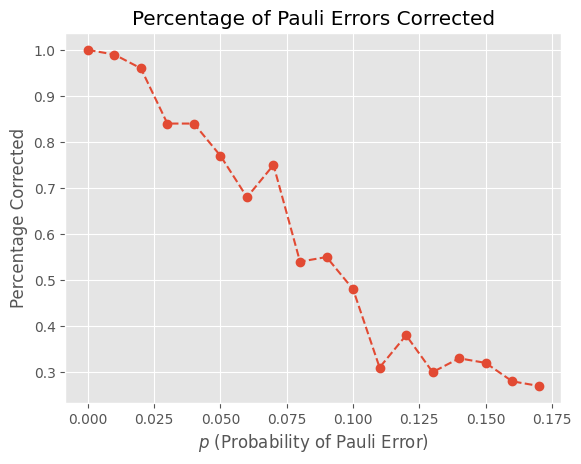

In [65]:
plt.plot(xs, ys, "--o");
plt.title("Percentage of Pauli Errors Corrected")
plt.xlabel("$p$ (Probability of Pauli Error)")
plt.ylabel("Percentage Corrected")

# plt.savefig("steane.png")

plt.show()

Below is the hard coded data from one run, with $1000$ repetitions per $p$:

In [70]:
xs_found_1000_steanes = np.array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17])
ys_found_1000_steanes = np.array([1.   , 0.989, 0.939, 0.894, 0.834, 0.759, 0.701, 0.625, 0.561,
       0.522, 0.472, 0.437, 0.399, 0.376, 0.321, 0.314, 0.247, 0.255])

Here is the table for that run:

|   $p$   | percentage |
|---------|:----------:|
| $0.00$  |   $1.000$   |
| $0.01$  |   $0.989$   |
| $0.02$  |   $0.939$   |
| $0.03$  |   $0.894$   |
| $0.04$  |   $0.834$   |
| $0.05$  |   $0.759$   |
| $0.06$  |   $0.701$   |
| $0.07$  |   $0.625$   |
| $0.08$  |   $0.561$   |
| $0.09$  |   $0.522$   |
| $0.10$  |   $0.472$   |
| $0.11$  |   $0.437$   |
| $0.12$  |   $0.399$   |
| $0.13$  |   $0.376$   |
| $0.14$  |   $0.321$   |
| $0.15$  |   $0.314$   |
| $0.16$  |   $0.247$   |
| $0.17$  |   $0.255$   |

Here is the corresponding graph:

<img src="steane-1000.png" alt="Percentage Corrected for One Run"/>